In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BuildTardisData import linear_data
from BacktestStrategy import backtest_strategy

### Lags and delays for optimal accuracy

In [2]:
l, d = 1, 2

### Backtesting results for past 3 months data

In [3]:

def read_datasets():
    
    # Get all file names in the directory
    quotes, trades = os.listdir("D:\Quotes"), os.listdir("D:\Trades")
    
    # Loop through each file
    for quote, trade in zip(quotes, trades):
        
        file_path_q = os.path.join("D:\Quotes", quote)
        file_path_t = os.path.join("D:\Trades", trade)
            
        # Read the dataset using pandas
        df1 = pd.read_csv(file_path_q)
        df2 = pd.read_csv(file_path_t)
    
        # Yield combined dataset
        yield linear_data(df1, df2, l=l, d=d), quote[23:33]


We will be using one day's data to train the model and predict the next day.

**Assumptions:**
1. Initial Portfolio Value = $30,000
2. This includes the price to take one position at day open plus maintenance margin

### Profits for each trading day (Before Transaction Costs & Using Original MPB Formula) 

In [5]:
Profits_dict = {}
vol_dict = {}
datasets = read_datasets()
train, date = next(datasets)
for i in range(1,122):
    test, date = next(datasets)
    df = backtest_strategy(train, test, threshold=0.1, l=l, optimise=True)
    train = test
    Profits_dict[date] = sum(df["Trade Cost"])
    vol_dict[date] = df.iloc[-1,3]
    if i%50 == 0:
        print(Profits_dict)

{'2022-12-29': 7297.200000000481, '2022-12-30': 5564.300000000065, '2022-12-31': 3102.7000000003864, '2023-01-01': 1240.4000000000233, '2023-01-02': 2446.4000000001106, '2023-01-03': 5047.900000000383, '2023-01-04': 7216.200000000044, '2023-01-05': 4624.20000000023, '2023-01-06': 4010.1000000000276, '2023-01-07': 1152.0000000000946, '2023-01-08': 12.899999999997817, '2023-01-09': 11400.700000000164, '2023-01-10': 8545.800000000228, '2023-01-11': 10220.70000000023, '2023-01-12': 47277.9000000012, '2023-01-13': 54231.3000000023, '2023-01-14': 90378.50000000063, '2023-01-15': 47684.60000000194, '2023-01-16': 66847.40000000162, '2023-01-17': 56430.90000000089, '2023-01-18': 70275.20000000209, '2023-01-19': 30649.700000000666, '2023-01-20': 47557.700000001045, '2023-01-21': 67843.00000000092, '2023-01-22': 49232.20000000129, '2023-01-23': 53776.3000000017, '2023-01-24': 50656.80000000195, '2023-01-25': 64781.60000000147, '2023-01-26': 52487.90000000074, '2023-01-27': 50037.100000001155, '20

In [8]:
profits_df = pd.DataFrame(Profits_dict.values(), Profits_dict.keys(), columns=["Profit"])
profits_df

,Profit
2022-12-29,7297.2
2022-12-30,5564.3
2022-12-31,3102.7
2023-01-01,1240.4
2023-01-02,2446.4
...,...
2023-04-24,52703.8
2023-04-25,46205.3
2023-04-26,85693.9
2023-04-27,96499.0


In [8]:
vol_df = pd.DataFrame(vol_dict.values(), vol_dict.keys(), columns=["Volume"])
vol_df

,Volume
2022-12-29,11820
2022-12-30,4594
2022-12-31,3974
2023-01-01,848
2023-01-02,1966
...,...
2023-04-24,70358
2023-04-25,62688
2023-04-26,120562
2023-04-27,142894


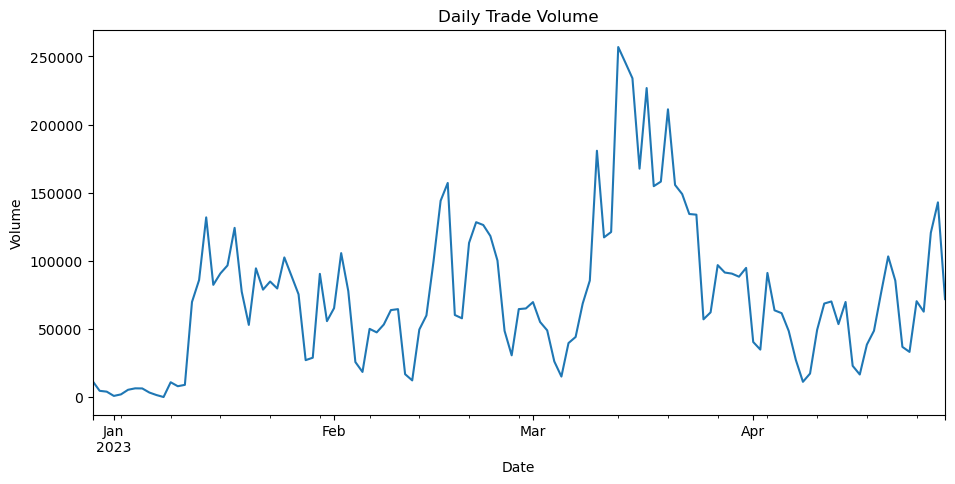

In [10]:
vol_df.index = pd.to_datetime(vol_df.index)
plt.title('Daily Trade Volume')
vol_df["Volume"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Portfolio Profit and Returns Graph

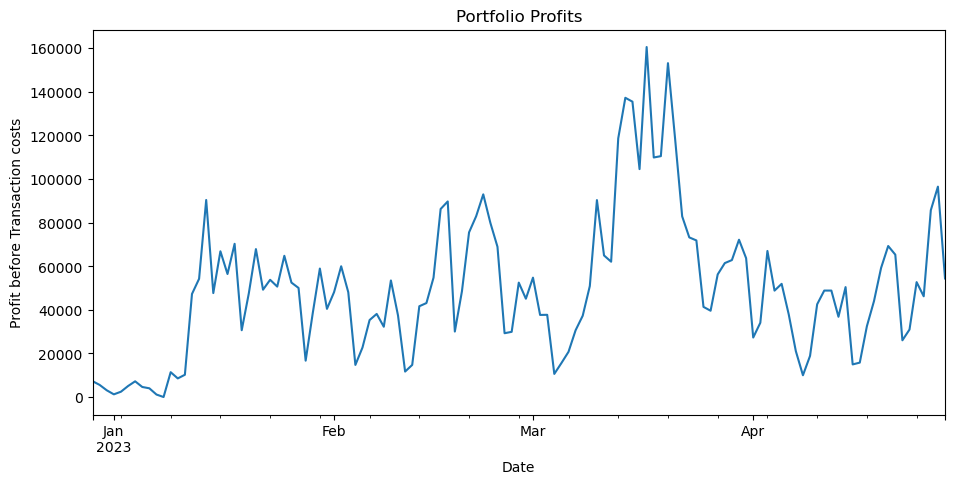

In [30]:
profits_df.index = pd.to_datetime(profits_df.index)
plt.title('Portfolio Profits')
profits_df["Profit"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Profit before Transaction costs')
plt.show()

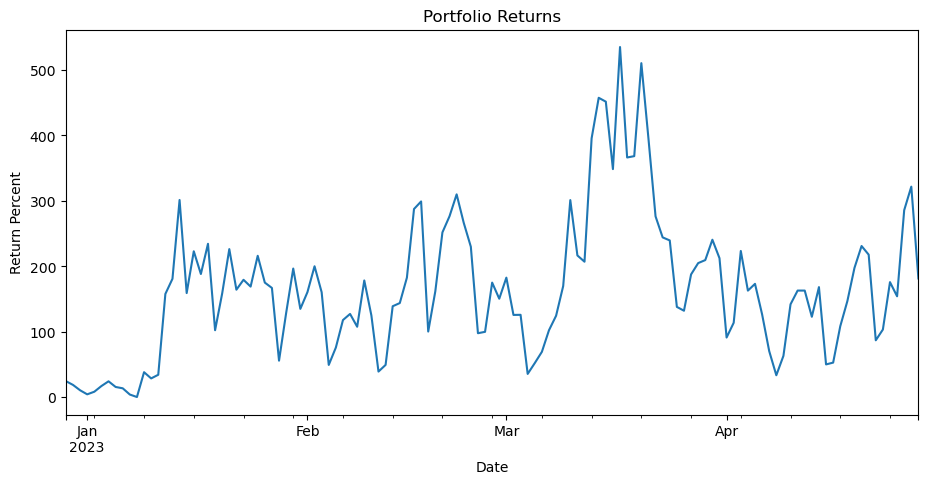

In [31]:
profits_df["Return Percent"] = (profits_df["Profit"]/30_000)*100
plt.title('Portfolio Returns')
profits_df["Return Percent"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Return Percent')
plt.show()

### Sharpe Ratio and Daily Drawdown

In [20]:
def calculate_sharpe_ratio(returns_data, risk_free_rate):
    
    # Calculate portfolio returns and volatility
    portfolio_returns = np.mean(returns_data)
    portfolio_volatility = np.std(returns_data)

    # Calculate excess returns
    excess_returns = portfolio_returns - risk_free_rate

    # Calculate Sharpe ratio
    sharpe_ratio = excess_returns / portfolio_volatility

    return sharpe_ratio

In [32]:
display("Sharpe Ratio of the Portfolio is:", calculate_sharpe_ratio(profits_df["Return Percent"], 4.5))

'Sharpe Ratio of the Portfolio is:'

1.4897153995347487

Although, the strategy seems quite successfull, there is a lot of volatilty in the returns, the returns range from less than 5 percent to greater than 500, and therefore the sharpe ratio is rather low.

In [33]:
np.std(profits_df["Return Percent"])

108.28360340876769

### Given the dataset, I have chosen a rolling window of 7 days to calculate the daily drawdowns.

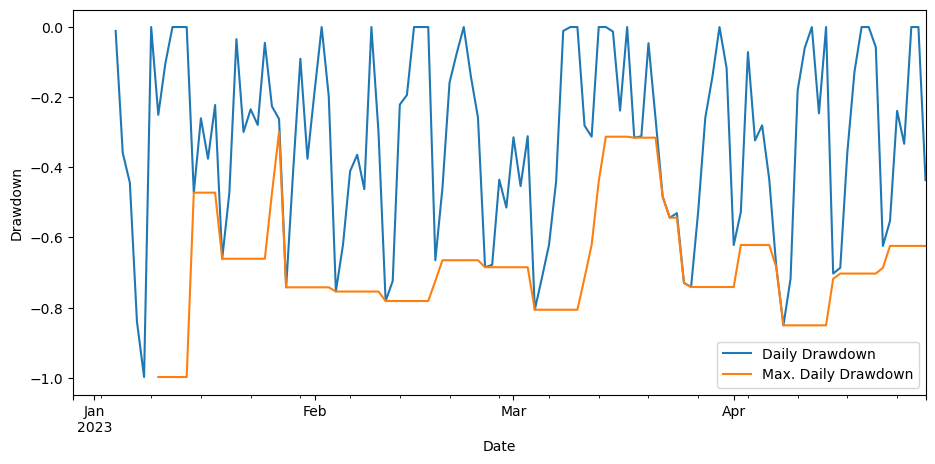

In [35]:
# We are going to use a trailing 1 trading day window
window = 7

# Calculate the max drawdown in the past window days for each day in the series.
Roll_Max = profits_df["Return Percent"].rolling(window).max()
Daily_Drawdown = profits_df["Return Percent"]/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window).min()

# Plot the results
Daily_Drawdown.plot(figsize=(11,5), label='Daily Drawdown')
Max_Daily_Drawdown.plot(figsize=(11,5), label='Max. Daily Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

### Profits for each trading day (Before Transaction Costs & Using Updated MPB Formula) 

In [13]:
def read_datasets():
    
    # Get all file names in the directory
    quotes, trades = os.listdir("D:\Quotes"), os.listdir("D:\Trades")
    
    # Loop through each file
    for quote, trade in zip(quotes, trades):
        
        file_path_q = os.path.join("D:\Quotes", quote)
        file_path_t = os.path.join("D:\Trades", trade)
            
        # Read the dataset using pandas
        df1 = pd.read_csv(file_path_q)
        df2 = pd.read_csv(file_path_t)
    
        # Yield combined dataset
        yield linear_data(df1, df2, l=l, d=d, mpb='updated'), quote[23:33]

In [14]:
Profits_dict = {}
datasets = read_datasets()
train, date = next(datasets)
for i in range(1,122):
    test, date = next(datasets)
    df = backtest_strategy(train, test, threshold=0.1, l=l, optimise=True)
    train = test
    Profits_dict[date] = sum(df["Trade Cost"])
    vol_dict[date] = df.iloc[-1,3]
    if i%50 == 0:
        print(Profits_dict)

{'2022-12-29': 7232.10000000065, '2022-12-30': 5947.400000000231, '2022-12-31': 3085.7000000003354, '2023-01-01': 1393.100000000013, '2023-01-02': 2851.4000000001142, '2023-01-03': 4957.7000000003645, '2023-01-04': 7869.000000000178, '2023-01-05': 4617.700000000052, '2023-01-06': 4392.900000000052, '2023-01-07': 1214.2000000000844, '2023-01-08': 280.3999999999869, '2023-01-09': 11631.700000000212, '2023-01-10': 8693.800000000243, '2023-01-11': 10590.300000000374, '2023-01-12': 48074.10000000136, '2023-01-13': 54943.00000000223, '2023-01-14': 94067.29999999983, '2023-01-15': 48566.000000002576, '2023-01-16': 68253.40000000237, '2023-01-17': 57353.300000001174, '2023-01-18': 72927.40000000312, '2023-01-19': 30521.200000001263, '2023-01-20': 48025.70000000109, '2023-01-21': 70500.000000002, '2023-01-22': 51215.7000000017, '2023-01-23': 55456.70000000216, '2023-01-24': 51128.200000002354, '2023-01-25': 65995.20000000187, '2023-01-26': 53536.10000000039, '2023-01-27': 50610.80000000128, '20

In [38]:
profits_df = pd.DataFrame(Profits_dict.values(), Profits_dict.keys(), columns=["Profit"])
profits_df

,Profit
2022-12-29,7232.1
2022-12-30,5947.4
2022-12-31,3085.7
2023-01-01,1393.1
2023-01-02,2851.4
...,...
2023-04-24,53753.6
2023-04-25,46656.5
2023-04-26,87918.4
2023-04-27,98075.2


In [15]:
vol_df = pd.DataFrame(vol_dict.values(), vol_dict.keys(), columns=["Volume"])
vol_df

,Volume
2022-12-29,11568
2022-12-30,5278
2022-12-31,4098
2023-01-01,986
2023-01-02,2178
...,...
2023-04-24,69548
2023-04-25,62766
2023-04-26,119434
2023-04-27,142310


### Portfolio Profit and Returns Graph

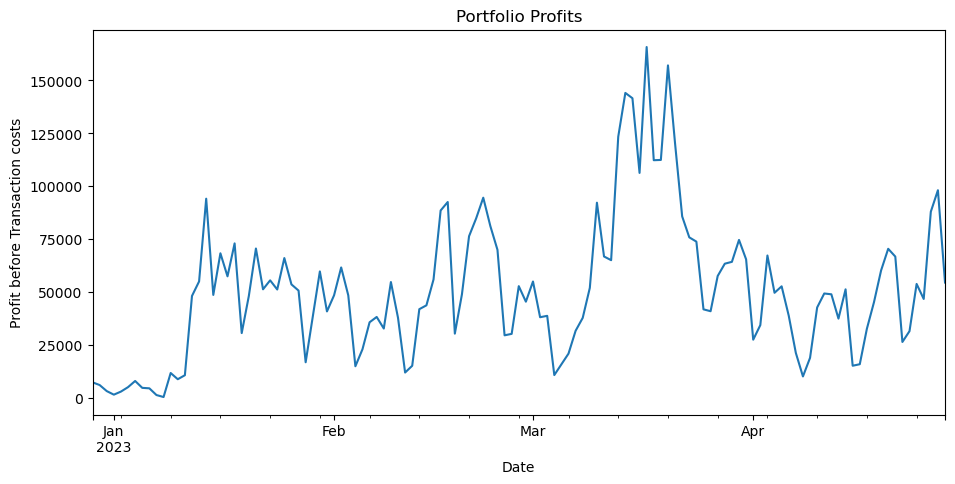

In [39]:
profits_df.index = pd.to_datetime(profits_df.index)
plt.title('Portfolio Profits')
profits_df["Profit"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Profit before Transaction costs')
plt.show()

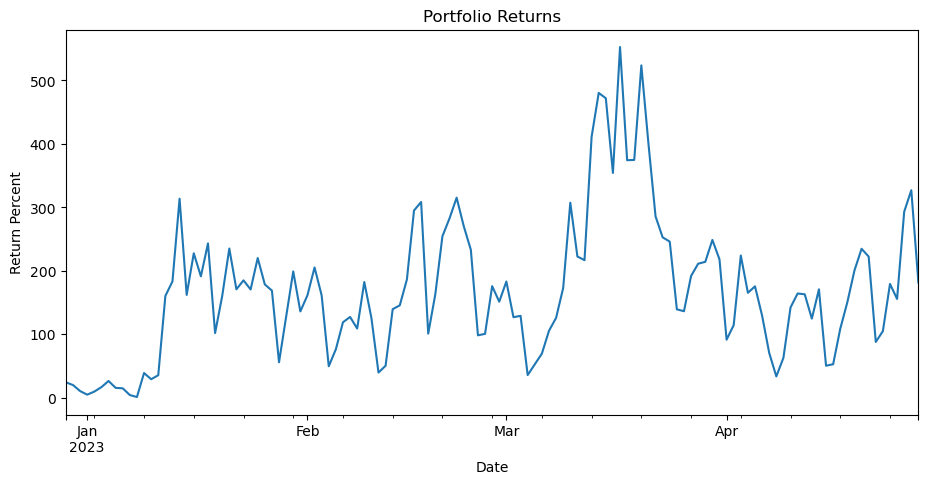

In [40]:
profits_df["Return Percent"] = (profits_df["Profit"]/30_000)*100
plt.title('Portfolio Returns')
profits_df["Return Percent"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Return Percent')
plt.show()

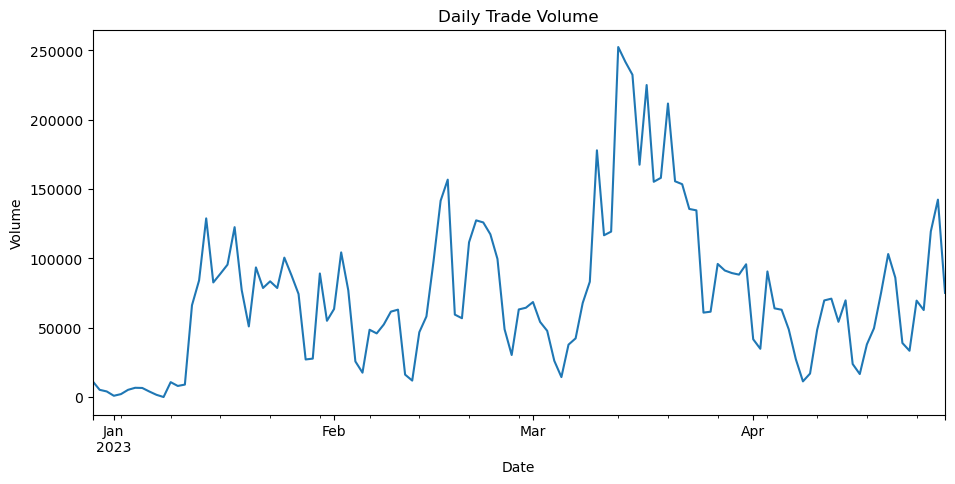

In [16]:
vol_df.index = pd.to_datetime(vol_df.index)
plt.title('Daily Trade Volume')
vol_df["Volume"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Share Ratio and Daily Drawdown

In [41]:
display("Sharpe Ratio of the Portfolio is:", calculate_sharpe_ratio(profits_df["Return Percent"], 4.5))

'Sharpe Ratio of the Portfolio is:'

1.4743302291222844

In [42]:
np.std(profits_df["Return Percent"])

111.7111710935228

No improvements here!!

### Given the dataset, I have chosen a rolling window of 7 days to calculate the daily drawdowns.

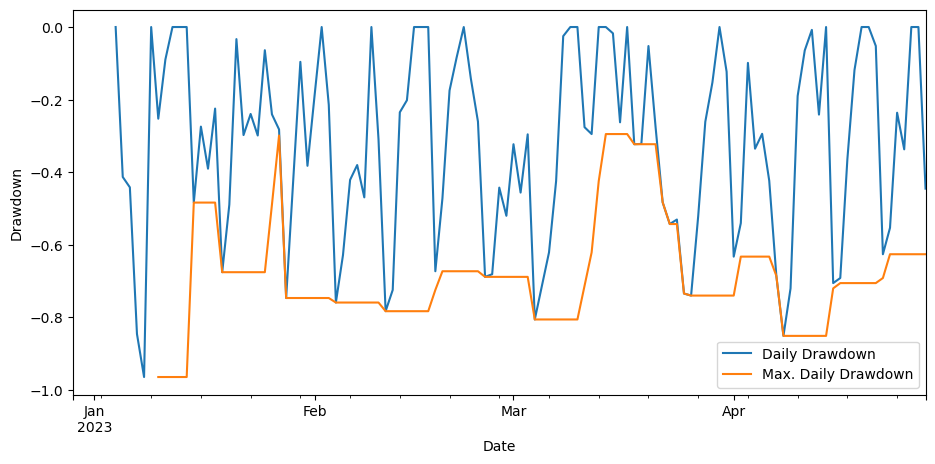

In [43]:
# We are going to use a trailing 1 trading day window
window = 7

# Calculate the max drawdown in the past window days for each day in the series.
Roll_Max = profits_df["Return Percent"].rolling(window).max()
Daily_Drawdown = profits_df["Return Percent"]/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window).min()

# Plot the results
Daily_Drawdown.plot(figsize=(11,5), label='Daily Drawdown')
Max_Daily_Drawdown.plot(figsize=(11,5), label='Max. Daily Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

Both of these perform the same with no statistically significant deviation from each other.